<a href="https://colab.research.google.com/github/BingHungLee/BHAI-Daily-Practice/blob/main/%5B20210715%5D_NH3_usage_prediction_for_SCR_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np                
import pandas as pd              
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import os

from sklearn.model_selection import GridSearchCV       #Import Optimize Solution Package:"GridSearchCV"
from sklearn.decomposition import PCA    #Import PCA Package
from matplotlib import pyplot    
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
!git clone https://github.com/BingHungLee/Dataset.git

fatal: destination path 'Dataset' already exists and is not an empty directory.


In [3]:
cd /content/Dataset

/content/Dataset


In [4]:
df_0 = pd.read_csv("HYSCR.csv",header =2,index_col =0,parse_dates=True,squeeze=False) 
df_0

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,NOx inlet ppm,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,NOx stack ppm,stack O2 %
time,,,,,,,,,,,,
2021-05-24 00:00:00,55.304115,42.715000,494.679565,3.606840,117.500000,380.624115,450.707703,67.082214,170.042999,519586.1563,34,4.100000
2021-05-24 00:01:00,55.303406,42.870003,494.649719,3.608348,117.500000,380.643066,450.705414,67.081169,170.059525,516950.0938,34,4.100000
2021-05-24 00:02:00,55.302696,42.814999,494.619873,3.609855,117.500000,380.662048,450.703125,67.080124,170.076065,524077.5938,34,4.100000
2021-05-24 00:03:00,55.301991,43.015396,494.589996,3.611363,117.500000,380.681030,450.700836,67.079086,170.092606,527261.3750,34,4.100000
2021-05-24 00:04:00,55.301281,42.815395,494.560150,3.612871,117.500000,380.699982,450.698547,67.078041,170.109131,530751.0625,34,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 23:56:00,48.740509,42.628273,416.178619,3.610745,123.067322,353.241791,376.109558,56.500000,164.920258,451640.4688,32,4.253667
2021-06-06 23:57:00,48.740532,42.451469,416.164856,3.607482,123.059601,353.224915,376.110596,56.500000,165.045990,451696.5000,32,4.254084
2021-06-06 23:58:00,48.740551,42.651470,416.151093,3.604220,123.051880,353.208038,376.111633,56.500000,165.171722,448002.9063,32,4.254501


## Data Observation and Preprocessing

In [5]:
#Check NAN Values
df_0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15506 entries, 2021-05-24 00:00:00 to 2021-06-07 00:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coal T/H             15506 non-null  float64
 1   OFA T/H              15506 non-null  float64
 2   steam flow T/H       15506 non-null  float64
 3   GAH inlet O2 %       15506 non-null  float64
 4   NOx inlet ppm        15506 non-null  float64
 5   ECO outlet temp C    15506 non-null  float64
 6   FDF flow T/H         15506 non-null  float64
 7   FDF current A        15506 non-null  float64
 8   ammonia actual L/HR  15506 non-null  float64
 9   stack flow NM3/H     15506 non-null  float64
 10  NOx stack ppm        15506 non-null  int64  
 11  stack O2 %           15506 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB


In [6]:
#Drop NOx inlet ppm and NOx stack ppm
df_1 = df_0.drop(['NOx inlet ppm','NOx stack ppm'],axis =1)
df_1

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,stack O2 %
time,,,,,,,,,,
2021-05-24 00:00:00,55.304115,42.715000,494.679565,3.606840,380.624115,450.707703,67.082214,170.042999,519586.1563,4.100000
2021-05-24 00:01:00,55.303406,42.870003,494.649719,3.608348,380.643066,450.705414,67.081169,170.059525,516950.0938,4.100000
2021-05-24 00:02:00,55.302696,42.814999,494.619873,3.609855,380.662048,450.703125,67.080124,170.076065,524077.5938,4.100000
2021-05-24 00:03:00,55.301991,43.015396,494.589996,3.611363,380.681030,450.700836,67.079086,170.092606,527261.3750,4.100000
2021-05-24 00:04:00,55.301281,42.815395,494.560150,3.612871,380.699982,450.698547,67.078041,170.109131,530751.0625,4.100000
...,...,...,...,...,...,...,...,...,...,...
2021-06-06 23:56:00,48.740509,42.628273,416.178619,3.610745,353.241791,376.109558,56.500000,164.920258,451640.4688,4.253667
2021-06-06 23:57:00,48.740532,42.451469,416.164856,3.607482,353.224915,376.110596,56.500000,165.045990,451696.5000,4.254084
2021-06-06 23:58:00,48.740551,42.651470,416.151093,3.604220,353.208038,376.111633,56.500000,165.171722,448002.9063,4.254501


In [7]:
#Assess parameter correlation
df_1.corr()

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,stack O2 %
coal T/H,1.000000,0.547060,0.978031,-0.709856,0.813759,0.960025,0.979059,-0.495420,0.934071,-0.718714
OFA T/H,0.547060,1.000000,0.576088,-0.169916,0.584204,0.647854,0.606285,-0.153639,0.554233,-0.202981
steam flow T/H,0.978031,0.576088,1.000000,-0.683035,0.881713,0.983855,0.986302,-0.494336,0.942288,-0.718652
GAH inlet O2 %,-0.709856,-0.169916,-0.683035,1.000000,-0.533135,-0.613504,-0.647519,0.734602,-0.687451,0.841458
ECO outlet temp C,0.813759,0.584204,0.881713,-0.533135,1.000000,0.890533,0.874640,-0.507970,0.829308,-0.624434
FDF flow T/H,0.960025,0.647854,0.983855,-0.613504,0.890533,1.000000,0.986914,-0.443026,0.933533,-0.650417
FDF current A,0.979059,0.606285,0.986302,-0.647519,0.874640,0.986914,1.000000,-0.459747,0.937813,-0.679650
ammonia actual L/HR,-0.495420,-0.153639,-0.494336,0.734602,-0.507970,-0.443026,-0.459747,1.000000,-0.522597,0.758652
stack flow NM3/H,0.934071,0.554233,0.942288,-0.687451,0.829308,0.933533,0.937813,-0.522597,1.000000,-0.723942
stack O2 %,-0.718714,-0.202981,-0.718652,0.841458,-0.624434,-0.650417,-0.679650,0.758652,-0.723942,1.000000


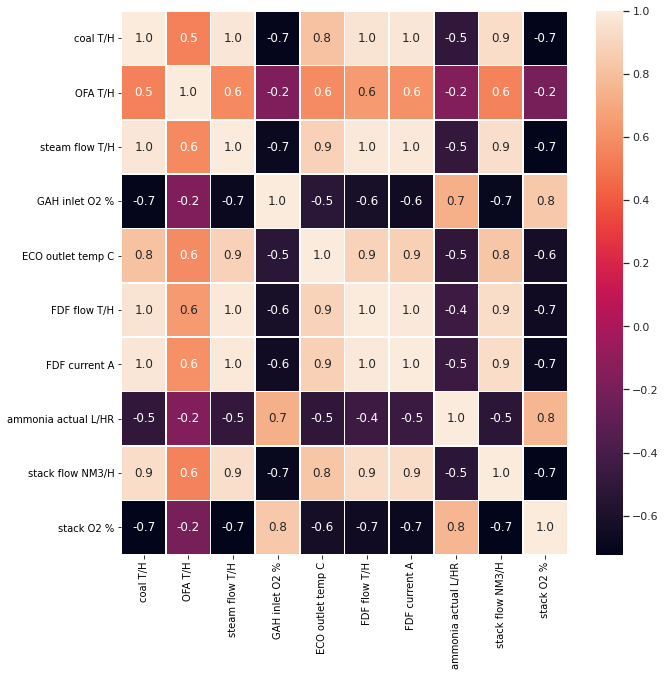

In [8]:
#Draw Heat Map

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.set(style="whitegrid")
sns.heatmap(df_1.corr(), annot=True, fmt="0.1f", linewidths=.5, ax=ax)

In [9]:
#Drop more un-relevant parameters
df_2 = df_1.drop(['OFA T/H','stack flow NM3/H'],axis=1)

## Define X and Y value

In [10]:
X = df_2.values
X

array([[ 55.3041153 , 494.6795654 ,   3.60684013, ...,  67.08221436,
        170.0429993 ,   4.0999999 ],
       [ 55.30340576, 494.6497192 ,   3.60834789, ...,  67.08116913,
        170.0595245 ,   4.0999999 ],
       [ 55.30269623, 494.619873  ,   3.60985541, ...,  67.0801239 ,
        170.0760651 ,   4.0999999 ],
       ...,
       [ 48.74055099, 416.1510925 ,   3.60421991, ...,  56.5       ,
        165.1717224 ,   4.25450087],
       [ 48.74057007, 416.1373291 ,   3.60095739, ...,  56.5       ,
        165.2974396 ,   4.25491762],
       [ 48.74059296, 416.1235657 ,   3.5999999 , ...,  56.5       ,
        165.423172  ,   4.25533438]])

In [11]:
y = df_2['ammonia actual L/HR'].values
y

array([170.0429993, 170.0595245, 170.0760651, ..., 165.1717224,
       165.2974396, 165.423172 ])

## Split Train and Test Data

In [12]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=45)

In [13]:
neighbors = np.arange(1,10)         #Set Container include 9 spots - array([1, 2, 3, 4, 5, 6, 7, 8, 9])
train_accuracy = np.empty(len(neighbors))  #array([4.9e-324, 9.9e-324, 1.5e-323, 2.0e-323, 2.5e-323, 3.0e-323,3.5e-323, 4.0e-323, 4.4e-323])
test_accuracy = np.empty(len(neighbors))  #array([4.9e-324, 9.9e-324, 1.5e-323, 2.0e-323, 2.5e-323, 3.0e-323,3.5e-323, 4.0e-323, 4.4e-323])

## Apply KNN Model

* Reference: [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [14]:
'''
#Example
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
print(neigh.predict([[1.5]]))
'''

'\n#Example\nX = [[0], [1], [2], [3]]\ny = [0, 0, 1, 1]\nfrom sklearn.neighbors import KNeighborsRegressor\nneigh = KNeighborsRegressor(n_neighbors=2)\nneigh.fit(X, y)\nprint(neigh.predict([[1.5]]))\n'

* Reference: [Python enumerate() 函数](https://www.runoob.com/python/python-func-enumerate.html)

In [15]:
#Decide K

for i,k in enumerate(neighbors):
  knn = KNeighborsRegressor(n_neighbors=k)

#knn = KNeighborsRegressor()

 * Reference: [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
 * Reference: [機器學習-ml-gridsearchcv-網格搜尋](https://martychen920.blogspot.com/2017/09/ml-gridsearchcv.html)
 * Reference: [Day 05：神經網路的效能調校](https://ithelp.ithome.com.tw/articles/10234203)
 * Reference: [Python机器学习笔记：Grid SearchCV（网格搜索）](https://www.cnblogs.com/wj-1314/p/10422159.html)

In [16]:
knn_grid = {'n_neighbors':[ i for i in range (1,10)]}  #Find the best neighbors number {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
grid_search = GridSearchCV(knn,param_grid = knn_grid,)    #knn is the model name
grid_search.fit(X_train, y_train)

# Get the average accuracy and standard deviation of cross validation
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"平均準確率: {mean}, 標準差: {stdev}, 參數組合: {param}")

平均準確率: 0.9998958594463548, 標準差: 2.646709228134037e-05, 參數組合: {'n_neighbors': 1}
平均準確率: 0.9998707695340148, 標準差: 4.613839233148866e-05, 參數組合: {'n_neighbors': 2}
平均準確率: 0.9998185119581103, 標準差: 5.1303261551217784e-05, 參數組合: {'n_neighbors': 3}
平均準確率: 0.9997572515040408, 標準差: 7.221169520584606e-05, 參數組合: {'n_neighbors': 4}
平均準確率: 0.9997207510012309, 標準差: 8.186960371560709e-05, 參數組合: {'n_neighbors': 5}
平均準確率: 0.9996751238408708, 標準差: 9.667067122231534e-05, 參數組合: {'n_neighbors': 6}
平均準確率: 0.9996331333086307, 標準差: 7.543023923902029e-05, 參數組合: {'n_neighbors': 7}
平均準確率: 0.9995871115035687, 標準差: 9.757237596052342e-05, 參數組合: {'n_neighbors': 8}
平均準確率: 0.9995097147349228, 標準差: 0.00010522156694715168, 參數組合: {'n_neighbors': 9}


* Reference: [Learning Model : Unsupervised Machine Learning_主成分分析（PCA）原理詳解](https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/preprocessing-data-%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90-pca-%E5%8E%9F%E7%90%86%E8%A9%B3%E8%A7%A3-afe1fd044d4f)
* Reference: [Day18-Scikit-learn介紹(10)_ Principal Component Analysis](https://ithelp.ithome.com.tw/articles/10206243)
* Reference: [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* Reference: [主成份分析(Principal Component Analysis, PCA)](http://120.118.226.200/member/hunght/%E6%B4%AA%E5%83%96%E9%BB%9B%E8%80%81%E5%B8%AB%E6%95%99%E6%9D%90(IEM)/Principal%20Component%20Analysis.pdf)

In [17]:
''''
print(X_train.shape)               #Print out the dimensions of X_train
print(X_train)
print(X_test.shape)               #Print out the dimensions of X_test
'''

pca = PCA (n_components=2)          #Name the PCA function as pca variable, and reduce the dimension to 2
X_train = pca.fit_transform(X_train)      #PCA training and conversion of X_train variables
X_test = pca.transform(X_test)         #PCA conversion of X_test variable
print(X_train.shape)               #Print out the dimensions of X_train
print(X_train)
print(X_test.shape)               #Print out the dimensions of X_test

(10389, 2)
[[ 76.10971249  28.04716283]
 [-35.85737641  -6.54324958]
 [-66.61155396   7.89179734]
 ...
 [ 74.09190085 -33.60296668]
 [-60.99930834  -0.24245896]
 [-52.73106314 -20.15133694]]
(5117, 2)


In [18]:
#Train After PCA
knn_grid = {'n_neighbors':[ i for i in range (1,10)]}  #Find the best neighbors number {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
grid_search = GridSearchCV(knn,param_grid = knn_grid,)    #knn is the model name
grid_search.fit(X_train, y_train)

# Get the average accuracy and standard deviation of cross validation
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"平均準確率: {mean}, 標準差: {stdev}, 參數組合: {param}")

平均準確率: 0.9997528600973966, 標準差: 4.470656018815046e-05, 參數組合: {'n_neighbors': 1}
平均準確率: 0.9997464662828722, 標準差: 3.702358652059392e-05, 參數組合: {'n_neighbors': 2}
平均準確率: 0.9997184715954457, 標準差: 5.007805995773614e-05, 參數組合: {'n_neighbors': 3}
平均準確率: 0.9996616827670722, 標準差: 5.7833647315204267e-05, 參數組合: {'n_neighbors': 4}
平均準確率: 0.9996416976906893, 標準差: 5.3060320736413425e-05, 參數組合: {'n_neighbors': 5}
平均準確率: 0.9995929041975925, 標準差: 5.9654605998741336e-05, 參數組合: {'n_neighbors': 6}
平均準確率: 0.9995619757168148, 標準差: 5.5018961270887916e-05, 參數組合: {'n_neighbors': 7}
平均準確率: 0.9995305432605728, 標準差: 5.9323160581550947e-05, 參數組合: {'n_neighbors': 8}
平均準確率: 0.9994917461888712, 標準差: 8.148661778508088e-05, 參數組合: {'n_neighbors': 9}


In [19]:
#Apply best Neighbors Number and train model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)  

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [20]:
train_accuracy[i] = knn.score(X_train, y_train) 
test_accuracy[i] = knn.score(X_test, y_test)
print("train_accuracy:",train_accuracy)
print("test_accuracy:",test_accuracy)

train_accuracy: [72.          0.          0.          0.         72.          0.
  0.          0.          0.99984121]
test_accuracy: [1.         0.         0.         0.         1.         0.
 0.         0.         0.99962228]


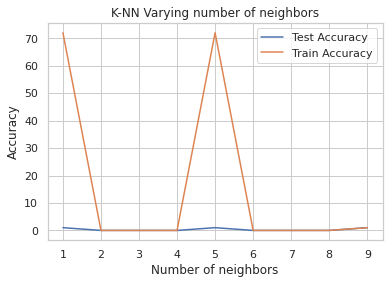

In [21]:
plt.title('K-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Test Accuracy')
plt.plot(neighbors, train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [22]:

y_pred = knn.predict(X_test)
r2_score(y_test, y_pred)

0.9996222815688616

In [23]:
X_all = pca.fit_transform(X)         #Input X and predict
y_pred_all = knn.predict(X_all)

In [24]:
#Calc ammonia actual L/min and  AI predict L/min Accuracy
r2_score(y, y_pred_all)

0.999749120753858

In [25]:
test_accuracy[i] = knn.score(X_all, y_pred_all) 
test_accuracy[i]

1.0

In [26]:
df_2.loc[:,'AI predict L/HR'] = pd.Series(y_pred_all, index=df_2.index)  
df_2.head()    

,coal T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack O2 %,AI predict L/HR
time,,,,,,,,,
2021-05-24 00:00:00,55.304115,494.679565,3.606840,380.624115,450.707703,67.082214,170.042999,4.1,170.109131
2021-05-24 00:01:00,55.303406,494.649719,3.608348,380.643066,450.705414,67.081169,170.059525,4.1,170.109131
2021-05-24 00:02:00,55.302696,494.619873,3.609855,380.662048,450.703125,67.080124,170.076065,4.1,170.109131
2021-05-24 00:03:00,55.301991,494.589996,3.611363,380.681030,450.700836,67.079086,170.092606,4.1,170.109131
2021-05-24 00:04:00,55.301281,494.560150,3.612871,380.699982,450.698547,67.078041,170.109131,4.1,170.109131


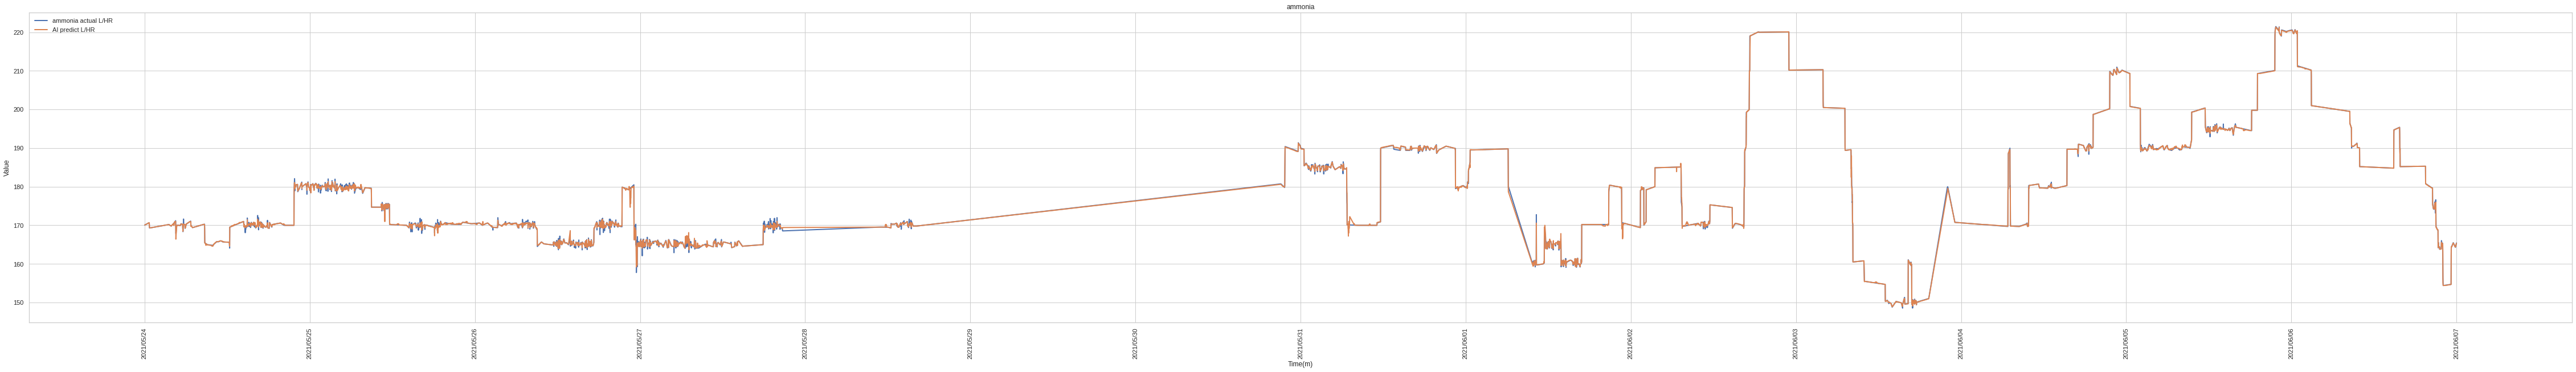

In [27]:
# Create fig: canvas panel and axes: a chart
fig, axes = plt.subplots(figsize=(80,10))

# Chart appearance setting: seaborn-darkgrid
plt.style.use('seaborn-darkgrid')

#x-axis: time series; y-axis: various parameters
plt.plot(df_2.index, df_2['ammonia actual L/HR'], label = 'ammonia actual L/HR', linewidth = 2)

plt.plot(df_2.index, df_2['AI predict L/HR'], label = 'AI predict L/HR', linewidth = 2)
#plt.plot(df_2.index, df_2['ammonia theory L/HR'], label = 'ammonia theory L/HR', linewidth = 2)

# X axis rotation font (90 degrees)
plt.xticks(rotation=90)

# WeekdayLocator (week), DayLocator (day)
axes.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set time format
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

# X-axis unit: Time; y-axis unit: Ammonia consumption; Figure title: ammonia; Setting icon description: loc=2 (upper left corner)
plt.xlabel("Time(m)")
plt.ylabel("Value")
plt.title("ammonia")
plt.legend(loc=2)

# Save as a picture, dpi is the resolution unit
plt.savefig("ammonia_0.png", dpi = 100)